In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math

### Ride Analysis: Time-Domain Response to Road Inputs:

The quarter-car model schematic is shown below:

<img src="../images/schematic.jpg" alt="schematic" width="200"/>

The equations of motions for the quarter-car suspension model shown above are [Gillespie, 1992]:

$$ m_\text{s}\ddot{z}_\text{s} + c_\text{s}\dot{z}_\text{s} + k_\text{s} z_\text{s} - c_\text{s} \dot{z}_\text{u} + k_\text{s} z_\text{u} = 0 $$ 
$$ m_\text{u}\ddot{z}_\text{u} + c_\text{s} \dot{z}_\text{u} + (k_\text{s} + k_\text{t}) z_\text{u} - c_\text{s} \dot{z}_\text{s} - k_\text{s} z_\text{s} - k_\text{t} z_\text{r}= 0$$ 

where

$z_\text{s}$ = sprung mass displacement\
$z_\text{u}$ = unsprung mass displacement\
$z_\text{r}$ = road elevation\
$m_\text{s}$ = sprung mass\
$m_\text{u}$ = unsprung mass\
$k_\text{s}$ = suspension stiffness (assumed linear here)\
$k_\text{t}$ = tire stiffness (assumed linear here)\
$c_\text{s}$ = suspension damping coefficient (assumed linear here)

To convert these equations to the first-order ODEs (so that we can solve them with ODE solvers), we use the following kinematic equations:

$$\begin{bmatrix} \dot{q}_1 \\ \dot{q}_2 \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$$

where 

$q_i$ = i-th generalized coordinate\
$u_i$ = i-th generalized speed

and note that

$$\begin{bmatrix} q_1 \\ q_2 \end{bmatrix} = \begin{bmatrix} z_s \\ z_u \end{bmatrix}$$

The equations of motions in state-space form become:

$$\begin{bmatrix} \dot{q}_1 \\ \dot{q}_2 \end{bmatrix} =\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$$

$$\begin{bmatrix} \dot{u}_1 \\ \dot{u}_2 \end{bmatrix} =
\begin{bmatrix} -c_\text{s}/m_\text{s} & c_\text{s}/m_\text{s} \\ c_\text{s}/m_\text{u} & -c_\text{s}/m_\text{u} \end{bmatrix}\begin{bmatrix} u_1 \\ u_2 \end{bmatrix} + 
\begin{bmatrix} -k_\text{s}/m_\text{s} & k_\text{s}/m_\text{s} \\ k_\text{s}/m_\text{u} & -(k_\text{t}+k_\text{s})/m_\text{u} \end{bmatrix}\begin{bmatrix} q_1 \\ q_2 \end{bmatrix} +
\begin{bmatrix} 0 \\ k_\text{t}z_\text{r}/m_\text{u}\end{bmatrix}
$$


### Road Definitions
Below, are different road defintions for the analysis. 

In [2]:
def step_road(t, vehicle_speed): 
    """
    This function returns the height of the road for a step road at a given
    travel time and for a given travel speed.
    
    Parameters:
    ---------
    t: float
        time of simulation [s]
    vehicle_speed: float
        vehicle travel speed [m/s] 

    Returns:
    -------
    road_height: float
        road height at time t [m]
    
    """    
    # Road Parameters:
    step_position = 2 # [m]
    step_height   = 0.05 # [m]

    # Calculate the vehicle position
    vehicle_position = vehicle_speed * t # [m]

    # Road Calculations:
    if vehicle_position >= step_position:
            road_height = step_height
    else:
            road_height = 0    
        
    return road_height

In [3]:
def ramp_road(t, vehicle_speed): 
    """
    This function returns the height of the road for a ramp road at a given
    travel time and for a given travel speed.
    
    Parameters:
    ---------
    t: float
        time of simulation [s]   
    vehicle_speed: float
        vehicle travel speed [m/s] 

    Returns:
    -------
    road_height: float
        road height at time t [m]
    
    """    
    # Road Parameters:
    ramp_position = 20 # [m]
    ramp_angle    = 10 # [deg]
    ramp_grade    = math.atan(math.radians(ramp_angle))

    # Calculate the vehicle position
    vehicle_position = vehicle_speed * t # [m]

    # Road Calculations:
    if vehicle_position >= ramp_position:
            road_height = ramp_grade*(vehicle_position - ramp_position)
    else:
            road_height = 0    
        
    return road_height

In [4]:
def any_road(t, vehicle_speed):

    zr = 0 # any road input in terms of t and vehicle_speed

    return zr

In [5]:
def get_road_input(t, vehicle_speed, road_type):
    """
    This function returns the height of the road for a ramp road at a given
    travel time and for a given travel speed.
    
    Parameters:
    ---------
    t: float
        time of simulation [s]   
    vehicle_speed: float
        vehicle travel speed [m/s] 
    road_type: string
        type of the road (it should be defined before)

    Returns:
    -------
    road_height: float
        road height at time t [m]
    """
    if road_type == 'step':
        road_height = step_road(t, vehicle_speed)

    if road_type == 'ramp':
        road_height = ramp_road(t, vehicle_speed)

    # Add any road_type of your choice here after defining it above
    
    return road_height

### Equations of Motion
The equations of motion (the state-space equations) are defined in the following function:

In [6]:
def eval_rhs(t, x, p, road_type):
    """
    This function returns the time derivative of the generalized coordinates dot{q} and
    speeds dot{u} by calculating the right-hand side of the state-space equations.
    
    Parameters:
    ---------
    t: float
        time of simulation [s]  
    x: array_like, shape(4,) 
        system state at time t: [q1, q2, u1, u2]   
    p: array_like, shape(7,)
        parameters of the system: 
        [sprung_mass, unsprung_mass, suspension_stiffness, tire_stiffness, suspension_damping, vehicle_speed, road_type]
    
    Returns:
    -------
    xd: ndarray, shape(4,)
        time derivative of the states: [qd1, qd2, ud1, ud2]  
    """  

    # Extract the parameters from p
    sprung_mass          = p[0] # [kg]
    unsprung_mass        = p[1] # [kg]
    suspension_stiffness = p[2] # [N/m]
    tire_stiffness       = p[3] # [N/m]
    suspension_damping   = p[4] # [N/m/s]
    vehicle_speed        = p[5] # [m/s]

    # Extract the state values from x
    q = x[:2] # generalized coordinates
    u = x[2:] # generalized speeds  

    # Renaming variables for ease of use and reading
    ms = sprung_mass
    mu = unsprung_mass
    ks = suspension_stiffness
    kt = tire_stiffness
    cs = suspension_damping

    # Evaluate the road input at the time t
    road_height = get_road_input(t, vehicle_speed, road_type)
    zr          = road_height
    
    # Damping and stiffness matrices
    C = np.array([ [-cs/ms, cs/ms], [cs/mu, -cs/mu] ])
    K = np.array([ [-ks/ms, ks/ms], [ks/mu, -(kt+ks)/mu] ])

    # Equations of motions
    qd = u
    ud = np.matmul(C,u)+ np.matmul(K, q) + np.array([0, kt/mu*zr])

    # return the time derivative of the states
    xd     = np.empty_like(x)
    xd[:2] = qd
    xd[2:] = ud
    
    return xd   

In [7]:
def plot_results(sol, zr_sol):
    """
    This function plots the state values in sol generated via scipy.ivp_sol
    
    Arguments:
    ---------
    sol: OdeSolution 
    solution of the scipy.ivp_sol
    
    Returns:
    -------
    Plots the states
    
    """
    fig, axes = plt.subplots(2, 2, sharex=True, sharey = False)
    fig.set_size_inches((10, 4.0))
    fig.tight_layout() 
    
    axes[0,0].plot(sol.t, sol.y[0],  label = '$q_1=z_s$')
    axes[0,0].plot(sol.t, zr_sol,    label = '$z_r$', linestyle = '--')
    axes[0,0].set_title('Sprung Mass')
    axes[0,1].plot(sol.t, sol.y[1],  label = '$q_2=z_u$')
    axes[0,1].plot(sol.t, zr_sol,    label = '$z_r$', linestyle = '--')
    axes[0,1].set_title('Unprung Mass')
    axes[1,0].plot(sol.t, xd_sol[2], label = '$\\dot{u}_1= \\ddot{z}_s$')
    axes[1,1].plot(sol.t, xd_sol[3], label = '$\\dot{u}_2= \\ddot{z}_u$')
      
    axes[0,0].legend()
    axes[0,1].legend()
    axes[1,0].legend()
    axes[1,1].legend()

    
    axes[0,0].set_ylabel('Disp. [m]')
    axes[1,0].set_ylabel('Acc. $[m/s^2]$')
    axes[1,0].set_xlabel('Time [s]');
    axes[1,1].set_xlabel('Time [s]');

### Parameters of the Quarter-Car Model
Define the parameters and the initial conditions of the system

In [8]:
# Set the parameter values and the initial conditions

# Vehicle Parameters
sprung_mass_val          = 250      # [kg]
unsprung_mass_val        = 50       # [kg]
suspension_stiffness_val = 7000     # [N/m]
tire_stiffness_val       = 100000   # [N/m]
suspension_damping_val   = 1000     # [N/m/s]
vehicle_speed_val        = 60/3.6   # [kph]->[m/s]
p_vals                   = np.array([sprung_mass_val, unsprung_mass_val,
                                     suspension_stiffness_val, tire_stiffness_val,
                                     suspension_damping_val, vehicle_speed_val])

# Road type
road_type_val = 'step'

# Simulation time
t0 = 0
tf = 7
ts  = np.linspace(0,5,300)

# Initial values of the states
q0_vals = np.array([0, 0])
u0_vals = np.array([0, 0])

### Time-Domain Simulation
Perform the simulation using solve_ivp and plot the results

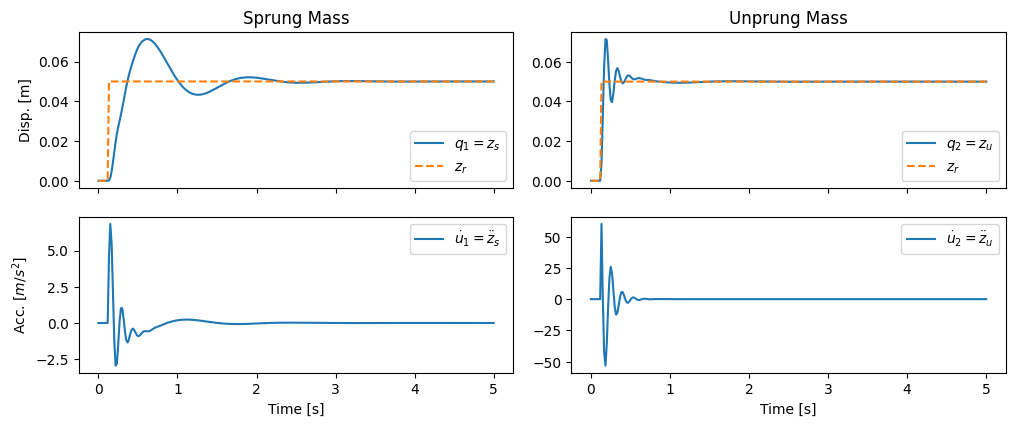

In [9]:
# Solve the initial value problem and extract the state values
x0_vals = np.empty(4)
x0_vals[:2] = q0_vals
x0_vals[2:] = u0_vals
sol = solve_ivp(eval_rhs, t_span = [t0, tf], y0 = x0_vals,
                t_eval=ts, method='RK45', args=(p_vals, road_type_val), atol = 1e-6, rtol = 1e-6)

# Calculate the time derivative of the generalized coordinates and speeds
xd_sol = np.empty_like(sol.y)
for i in range(len(sol.t)):
    xd_sol[:,i] = eval_rhs(sol.t[i], sol.y[:,i], p_vals, road_type_val)

# Get the road trajectory
zr_sol = np.empty_like(sol.t)
for i in range(len(sol.t)):
    zr_sol[i] = get_road_input(sol.t[i], vehicle_speed_val, road_type_val)

# Plot the results
plot_results(sol, zr_sol)

### References
- Gillespie, T. (1992). Fundamentals of vehicle dynamics. SAE international.
- Rill, G., & Castro, A. A. (2020). Road vehicle dynamics: fundamentals and modeling with MATLAB®. CRC Press.